# IMPORTS

In [1]:
import os
from time import time

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

from utils.write import write

2023-04-13 08:37:37.898186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DATA

In [2]:
test_dataframe = pd.read_csv('../data_frames/test_dataframe.csv', sep=',', names=['id']).astype(str)
validation_dataframe = pd.read_csv('../data_frames/validation_dataframe.csv', sep=',', names=['id', 'class']).astype(
    str)
train_dataframe = pd.read_csv('../data_frames/train_dataframe.csv', sep=',', names=['id', 'class']).astype(str)

# PLOT DATA

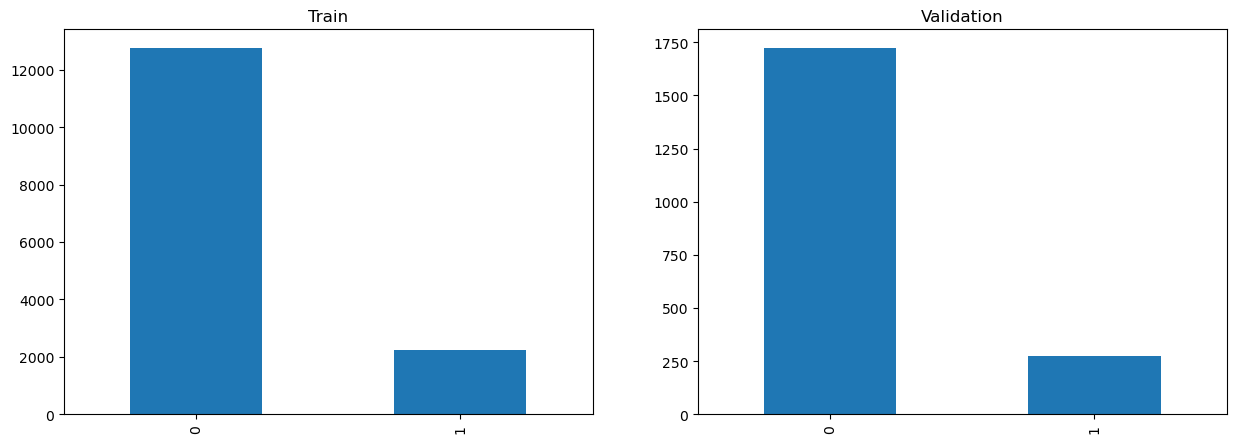

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
train_dataframe['class'].value_counts().plot(kind='bar', ax=ax[0], title='Train')
validation_dataframe['class'].value_counts().plot(kind='bar', ax=ax[1], title='Validation')
plt.show()

# CALCULATE CLASS WEIGHTS

In [4]:
train = train_dataframe['class'].values
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train), y=train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

{0: 0.5876821814762576, 1: 3.351206434316354}


In [5]:
data_dir_path = os.path.join(os.getcwd(), '../data/data/')
batch_size = 35
image_resize = (224, 224)

# DATA GENERATORS

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True
)

validation_data_gen = ImageDataGenerator(
    rescale=1. / 255.0
)

test_data_gen = ImageDataGenerator(
    rescale=1. / 255.0
)

# GENERATE DATA

In [7]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_dataframe,
    directory=data_dir_path,
    x_col='id',
    y_col='class',
    target_size=image_resize,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

validation_generator = validation_data_gen.flow_from_dataframe(
    dataframe=validation_dataframe,
    directory=data_dir_path,
    x_col='id',
    y_col='class',
    target_size=image_resize,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=data_dir_path,
    x_col='id',
    y_col=None,
    target_size=image_resize,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 15000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 5149 validated image filenames.


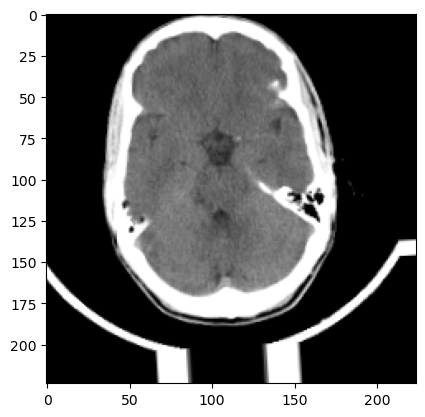

In [15]:
# See the augmented images
image_batch, label_batch = next(train_generator)
for j in range(0,35):
    image = image_batch[j]
    label = label_batch[j]
    plt.imshow(image, cmap='gray')

# AUGMENTED DATA

In [ ]:
from skimage import io


def imshow(img):
    io.imshow(img)
    io.show()


image_batch, label_batch = next(train_generator)
print(len(image_batch))
for i in range(0, 5):
    image = image_batch[i]
    label = label_batch[i]
    print(label)
    imshow(image)

# F1 SCORE METRIC

In [10]:
def score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# CALLBACKS

In [11]:
learn_rate = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=1e-7,
                               cooldown=1, min_lr=1e-7)

early_stop = EarlyStopping(monitor='val_score', min_delta=1e-4, patience=60, verbose=1, mode='max', baseline=None,
                           restore_best_weights=True)

checkpoint_path = "saved_models/model_weights.{epoch:02d}-{val_loss:.2f}--{val_score:.2f}.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, verbose=0)

tensorboard = TensorBoard(log_dir=f"logs/{time()}")

# MODEL

In [ ]:
model = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, padding='same',
               input_shape=(image_resize[0], image_resize[1], 1)),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=32, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(filters=128, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=128, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=128, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        Dropout(0.2),

        Flatten(),
        Dense(256),
        ReLU(),
        BatchNormalization(),
        Dense(256),
        ReLU(),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

In [ ]:
start = time()

model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=[score])

history = model.fit(train_generator, epochs=500, batch_size=batch_size, verbose=1,
                    validation_data=validation_generator, class_weight=class_weights,
                    callbacks=[early_stop, tensorboard, learn_rate, checkpoint_callback])

print(f"--------------------------- {time() - start} ---------------------------")


# PLOT

In [ ]:
plt.figure()
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('Model Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [ ]:
import itertools


def show(matrix, type):
    classes = [0, 1]
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix " + type)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# CONFUSION MATRIX TRAIN

In [ ]:
from sklearn.metrics import confusion_matrix

train_predicted_labels = model.predict(train_generator, verbose=1)
train_predicted_labels = np.round(train_predicted_labels).astype(int).reshape(-1, )
train_classes = train_generator.classes
cm = confusion_matrix(train_classes, train_predicted_labels)
show(cm, "Train")

# CONFUSION MATRIX VALIDATION

In [ ]:
val_predicted_labels = model.predict(validation_generator, verbose=1)
val_predicted_labels = np.round(val_predicted_labels).astype(int).reshape(-1, )
val_classes = validation_generator.classes
cm = confusion_matrix(val_classes, val_predicted_labels)
show(cm, "Validation")

# TEST

In [ ]:
from sklearn.metrics import classification_report

predicted_labels = model.predict(test_generator, verbose=1)
predicted_labels = np.round(predicted_labels).astype(int).reshape(-1, )

write(predicted_labels)

# CLASSIFICATION REPORT

In [ ]:
predicted_labels = model.predict(validation_generator, verbose=1)
predicted_labels = np.round(predicted_labels).astype(int).reshape(-1, )
val_classes = validation_generator.classes
print("Classification Report: ")
print(classification_report(val_classes, predicted_labels, target_names=['0', '1']))
print()

print(f"-----------------------------------------------------")
